In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('D:/AI-supply-chain-nestle/data/raw/extended_fmcg_demand_forecasting.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
# Mapping for relevance (focus on top 5; ignore others like Household/Personal Care for scope)
nestle_mapping = {
    'Snacks': 'Maggi (Snacks)',
    'Beverages': 'Nescafé (Beverages)',
    'Dairy': 'Milkmaid (Dairy)',
    'Confectionery': 'KitKat (Confectionery)',  # Assuming some map; if not present, we'll simulate later
    'Nutrition': 'Cerelac (Nutrition)'  # If present
}

In [4]:
relevant_cats = ['Snacks', 'Beverages', 'Dairy']  # Expand as data shows
df = df[df['Product_Category'].isin(relevant_cats)].copy()
df['Product'] = df['Product_Category'].map(lambda x: nestle_mapping.get(x, x))  # Map to full name
df['Category'] = df['Product_Category']

In [5]:
df.to_csv('D:/AI-supply-chain-nestle/data/raw/nestle_mapped_fmcg.csv', index=False)

In [6]:
print("Dataset shape after filtering:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nUnique Products:", df['Product'].unique())
print("\nDate range:", df['Date'].min(), "to", df['Date'].max())

Dataset shape after filtering: (590, 12)

First 5 rows:
        Date Product_Category  Sales_Volume      Price  Promotion  \
2 2022-01-03            Dairy           455   4.867987          0   
5 2022-01-06           Snacks          1256  19.254830          1   
6 2022-01-07            Dairy           987   8.902240          0   
7 2022-01-08            Dairy          1928  17.078661          0   
8 2022-01-09            Dairy          1963  12.946532          1   

  Store_Location  Weekday  Supplier_Cost  Replenishment_Lead_Time  \
2          Rural        0      13.302265                        9   
5          Urban        3      13.013454                        1   
6       Suburban        4      13.348355                        7   
7          Rural        5       3.351477                        4   
8          Rural        6      11.192678                        5   

   Stock_Level           Product Category  
2          245  Milkmaid (Dairy)    Dairy  
5          245    Maggi (S

In [7]:
df = pd.read_csv('D:/AI-supply-chain-nestle/data/raw/nestle_mapped_fmcg.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
print("Dataset shape:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset shape: (590, 12)

Missing values per column:
Date                       0
Product_Category           0
Sales_Volume               0
Price                      0
Promotion                  0
Store_Location             0
Weekday                    0
Supplier_Cost              0
Replenishment_Lead_Time    0
Stock_Level                0
Product                    0
Category                   0
dtype: int64


In [9]:
key_cols = ['Sales_Volume', 'Price', 'Supplier_Cost', 'Replenishment_Lead_Time', 'Stock_Level']
print("\nDescriptive Statistics for Key Columns:")
print(df[key_cols].describe())


Descriptive Statistics for Key Columns:
       Sales_Volume       Price  Supplier_Cost  Replenishment_Lead_Time  \
count    590.000000  590.000000     590.000000               590.000000   
mean    1052.974576   10.240137       7.657749                 4.974576   
std      542.157005    5.243972       4.178438                 2.535526   
min      106.000000    1.035718       0.509474                 1.000000   
25%      581.500000    5.881569       4.006978                 3.000000   
50%     1054.500000   10.094389       7.511452                 5.000000   
75%     1488.500000   14.675732      11.183615                 7.000000   
max     1997.000000   19.944485      14.993587                 9.000000   

       Stock_Level  
count   590.000000  
mean    271.588136  
std     132.332688  
min      50.000000  
25%     153.250000  
50%     266.000000  
75%     385.750000  
max     499.000000  


In [10]:
print("\nSales by Product:")
print(df.groupby('Product')['Sales_Volume'].agg(['mean', 'sum', 'count']).round(2))


Sales by Product:


                        mean     sum  count
Product                                    
Maggi (Snacks)       1013.29  192525    190
Milkmaid (Dairy)     1073.43  203952    190
Nescafé (Beverages)  1070.37  224778    210


In [11]:
print("\nAverage Sales by Store Location:")
print(df.groupby('Store_Location')['Sales_Volume'].mean().round(2))


Average Sales by Store Location:
Store_Location
Rural       1030.36
Suburban    1060.63
Urban       1068.13
Name: Sales_Volume, dtype: float64


In [12]:
print("\nAverage Sales by Promotion (0=No, 1=Yes):")
print(df.groupby('Promotion')['Sales_Volume'].mean().round(2))


Average Sales by Promotion (0=No, 1=Yes):
Promotion
0    1025.95
1    1080.00
Name: Sales_Volume, dtype: float64


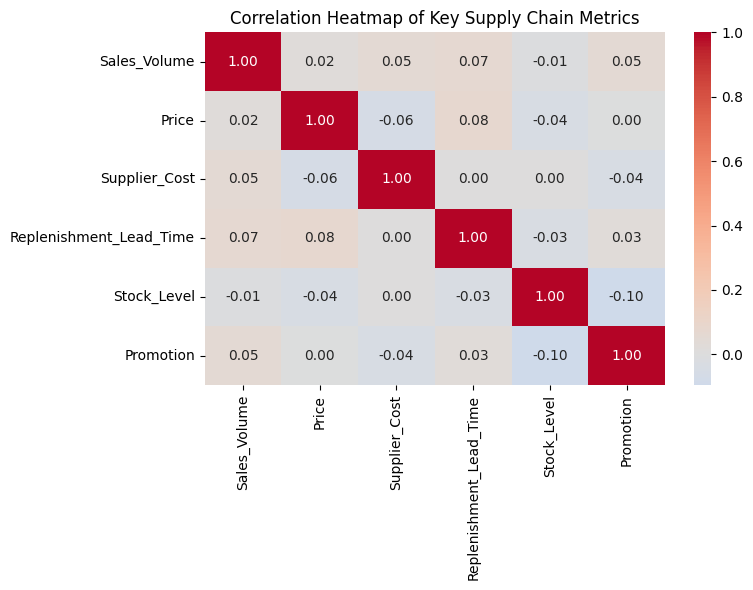

In [13]:
corr_matrix = df[key_cols + ['Promotion']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Key Supply Chain Metrics')
plt.tight_layout()
plt.show()

In [14]:
df.describe().to_csv('D:/AI-supply-chain-nestle/data/processed/exploration_stats.csv') 
print("\nExploration complete—check plots and stats above!")


Exploration complete—check plots and stats above!


In [15]:
print("Duplicates before cleaning:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

Duplicates before cleaning: 0
Duplicates after: 0


In [16]:
sales_mean = df['Sales_Volume'].mean()
sales_std = df['Sales_Volume'].std()
upper_bound = sales_mean + 3 * sales_std
lower_bound = max(0, sales_mean - 3 * sales_std)  # No negatives for sales
df['Sales_Volume_outlier'] = (df['Sales_Volume'] > upper_bound) | (df['Sales_Volume'] < lower_bound)
outlier_pct = df['Sales_Volume_outlier'].sum() / len(df) * 100
print(f"Outliers in Sales_Volume (>3σ): {outlier_pct:.1f}% ({df['Sales_Volume_outlier'].sum()} rows)")

Outliers in Sales_Volume (>3σ): 0.0% (0 rows)


In [17]:
df.loc[df['Sales_Volume'] > upper_bound, 'Sales_Volume'] = upper_bound
df.loc[df['Sales_Volume'] < lower_bound, 'Sales_Volume'] = lower_bound
df = df.drop('Sales_Volume_outlier', axis=1)  # Clean up

In [18]:
df['Monsoon_Month'] = df['Date'].dt.month.isin([7, 8]).astype(int)  # Jul-Aug dip
df['Festival_Month'] = df['Date'].dt.month.isin([10, 11, 12]).astype(int)  # Oct-Dec spike
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

In [19]:
df_monthly = df.groupby(['Year', 'Month', 'Product', 'Category', 'Store_Location']).agg({
    'Sales_Volume': ['sum', 'mean'],  # Total & avg monthly sales
    'Stock_Level': 'last',  # End-of-month stock
    'Price': 'mean',
    'Promotion': 'mean',  # Prop of promo days
    'Replenishment_Lead_Time': 'mean',
    'Supplier_Cost': 'mean',
    'Monsoon_Month': 'max',  # If any day in month is monsoon
    'Festival_Month': 'max'
}).reset_index()
df_monthly.columns = ['Year', 'Month', 'Product', 'Category', 'Store_Location', 'Monthly_Sales_Total', 
                      'Monthly_Sales_Avg', 'End_Stock_Level', 'Avg_Price', 'Promo_Proportion', 
                      'Avg_Lead_Time', 'Avg_Supplier_Cost', 'Monsoon_Month', 'Festival_Month']
df_monthly['Date'] = pd.to_datetime(df_monthly['Year'].astype(str) + '-' + df_monthly['Month'].astype(str) + '-01')

In [20]:
df.to_csv('D:/AI-supply-chain-nestle/data/processed/cleaned_daily_nestle.csv', index=False)
df_monthly.to_csv('D:/AI-supply-chain-nestle/data/processed/cleaned_monthly_nestle.csv', index=False)
print("\nCleaned data saved:")
print("- Daily shape:", df.shape)
print("- Monthly shape:", df_monthly.shape)
print("\nSample Monthly Data:")
print(df_monthly.head())


Cleaned data saved:
- Daily shape: (590, 17)
- Monthly shape: (256, 15)

Sample Monthly Data:
   Year  Month           Product Category Store_Location  Monthly_Sales_Total  \
0  2022      1    Maggi (Snacks)   Snacks          Rural               1528.0   
1  2022      1    Maggi (Snacks)   Snacks       Suburban               4455.0   
2  2022      1    Maggi (Snacks)   Snacks          Urban               1256.0   
3  2022      1  Milkmaid (Dairy)    Dairy          Rural               5973.0   
4  2022      1  Milkmaid (Dairy)    Dairy       Suburban               1900.0   

   Monthly_Sales_Avg  End_Stock_Level  Avg_Price  Promo_Proportion  \
0             1528.0              314   5.480050               1.0   
1             1485.0              148   8.589864               0.0   
2             1256.0              245  19.254830               1.0   
3             1194.6              457  11.584097               0.2   
4              950.0              337   9.376342               0.5  

In [21]:
df_monthly = pd.read_csv('D:/AI-supply-chain-nestle/data/processed/cleaned_monthly_nestle.csv')
df_monthly['Date'] = pd.to_datetime(df_monthly['Date'])
df_monthly['Year_Month'] = df_monthly['Date'].dt.to_period('M').astype(str)

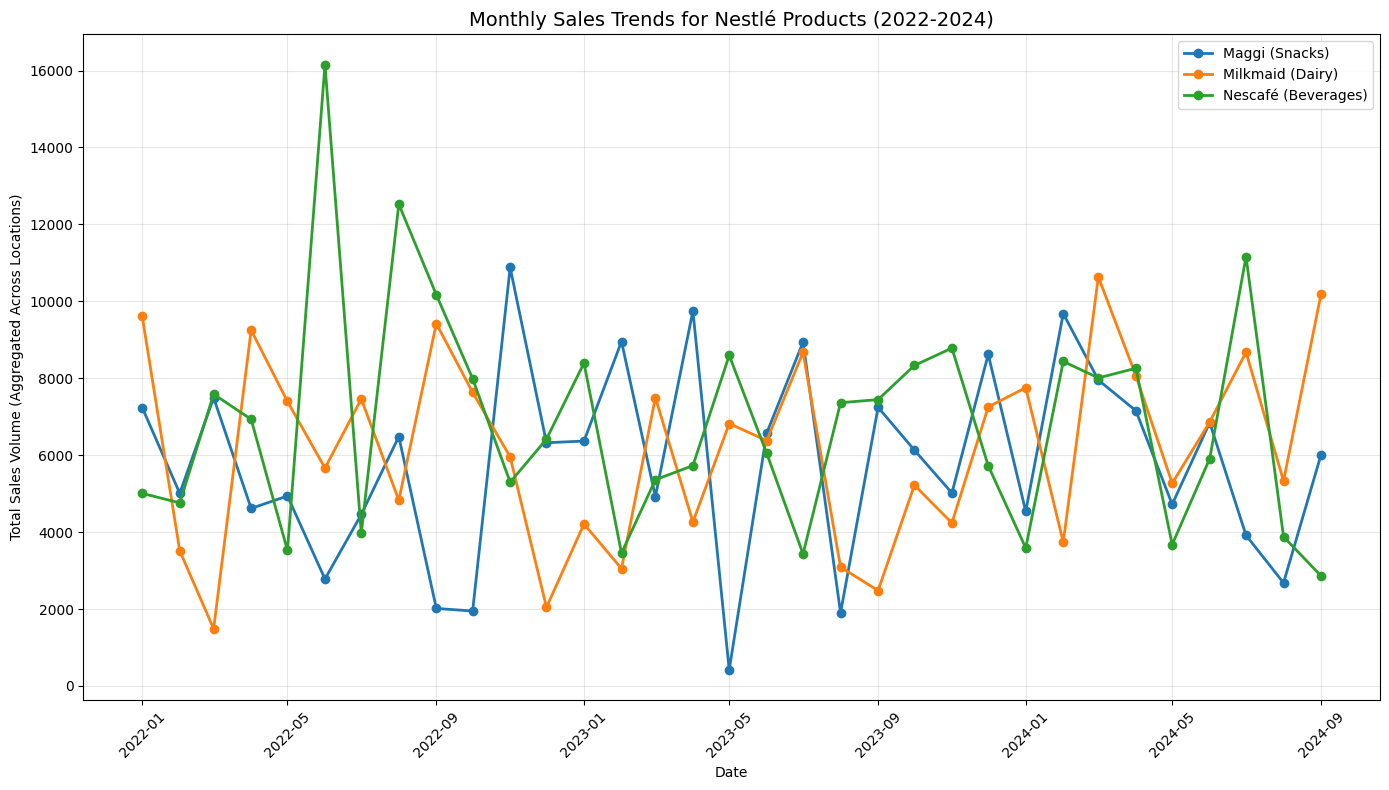

In [34]:
df_agg = df_monthly.groupby(['Date', 'Product'])['Monthly_Sales_Total'].sum().reset_index()
df_agg['Year_Month'] = df_agg['Date'].dt.to_period('M').astype(str)

plt.figure(figsize=(14, 8))
for product in df_agg['Product'].unique():
    prod_data = df_agg[df_agg['Product'] == product]
    plt.plot(prod_data['Date'], prod_data['Monthly_Sales_Total'], marker='o', label=product, linewidth=2)
plt.title('Monthly Sales Trends for Nestlé Products (2022-2024)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Sales Volume (Aggregated Across Locations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

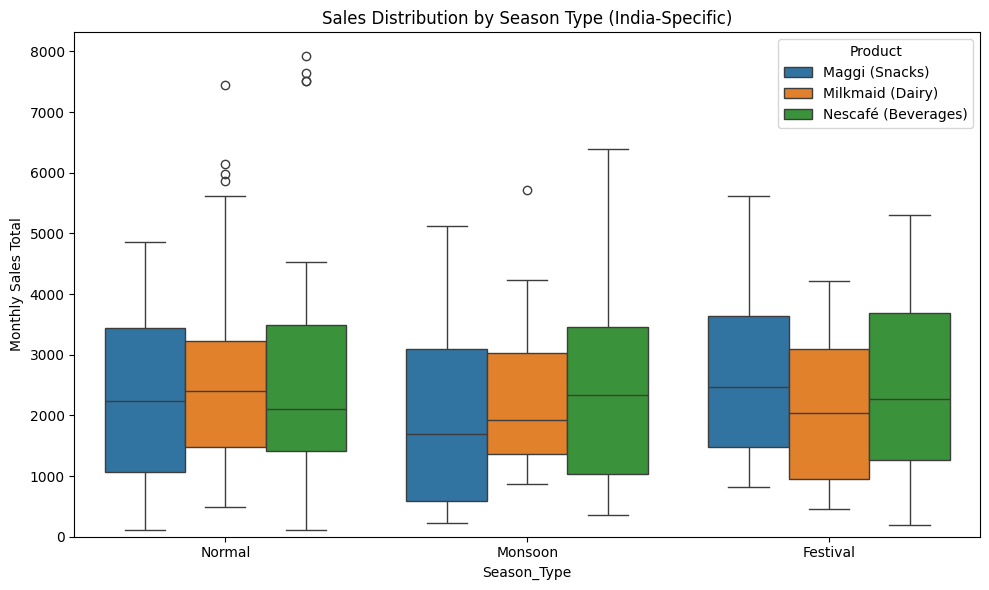

In [35]:
plt.figure(figsize=(10, 6))
df_monthly['Season_Type'] = 'Normal'
df_monthly.loc[df_monthly['Monsoon_Month'] == 1, 'Season_Type'] = 'Monsoon'
df_monthly.loc[df_monthly['Festival_Month'] == 1, 'Season_Type'] = 'Festival'
sns.boxplot(data=df_monthly, x='Season_Type', y='Monthly_Sales_Total', hue='Product')
plt.title('Sales Distribution by Season Type (India-Specific)')
plt.ylabel('Monthly Sales Total')
plt.ylim(0, None)
plt.tight_layout()
plt.show()

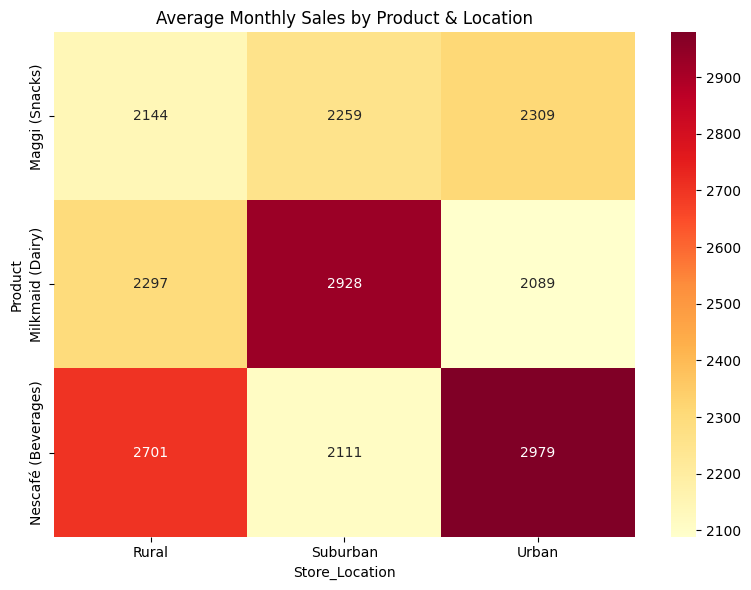

In [25]:
pivot_loc = df_monthly.pivot_table(values='Monthly_Sales_Total', index='Product', columns='Store_Location', aggfunc='mean').round(0)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_loc, annot=True, cmap='YlOrRd', fmt='.0f')
plt.title('Average Monthly Sales by Product & Location')
plt.tight_layout()
plt.show()

In [28]:
overall_avg = df_monthly['Monthly_Sales_Total'].mean()
festival_avg = df_monthly[df_monthly['Festival_Month'] == 1]['Monthly_Sales_Total'].mean()
normal_avg = df_monthly[df_monthly['Festival_Month'] == 0]['Monthly_Sales_Total'].mean()
festival_uplift = ((festival_avg / normal_avg - 1) * 100)
monsoon_avg = df_monthly[df_monthly['Monsoon_Month'] == 1]['Monthly_Sales_Total'].mean()
normal_avg_monsoon = df_monthly[df_monthly['Monsoon_Month'] == 0]['Monthly_Sales_Total'].mean()
monsoon_dip = ((monsoon_avg / normal_avg_monsoon - 1) * 100)
urban_avg = df_monthly[df_monthly['Store_Location'] == 'Urban']['Monthly_Sales_Total'].mean()
rural_avg = df_monthly[df_monthly['Store_Location'] == 'Rural']['Monthly_Sales_Total'].mean()
urban_rural_ratio = urban_avg / rural_avg
promo_avg = df_monthly[df_monthly['Promo_Proportion'] > 0]['Monthly_Sales_Total'].mean()
no_promo_avg = df_monthly[df_monthly['Promo_Proportion'] == 0]['Monthly_Sales_Total'].mean()
promo_lift = ((promo_avg / no_promo_avg - 1) * 100)

In [29]:
insights = {
    'Metric': ['Overall Avg Monthly Sales', 'Festival Uplift %', 'Monsoon Dip %', 'Urban vs. Rural Ratio', 'Promo Lift %'],
    'Value': [
        f"{overall_avg:.0f}",
        f"{festival_uplift:.1f}%",
        f"{monsoon_dip:.1f}%",
        f"{urban_rural_ratio:.1f}x",
        f"{promo_lift:.1f}%"
    ],
    'Implication': [
        'Baseline for forecasting models',
        'AI target: Predict spikes to avoid stockouts',
        'Optimize inventory buffers for Jul-Aug dips',
        'Prioritize urban routing; rural efficiency gains',
        'Dynamic promos could cut waste via better planning'
    ]
}
insights_df = pd.DataFrame(insights)
print("Key EDA Insights:\n")
print(insights_df.to_string(index=False))

Key EDA Insights:

                   Metric  Value                                        Implication
Overall Avg Monthly Sales   2427                    Baseline for forecasting models
        Festival Uplift %  -0.3%       AI target: Predict spikes to avoid stockouts
            Monsoon Dip %  -8.0%        Optimize inventory buffers for Jul-Aug dips
    Urban vs. Rural Ratio   1.0x   Prioritize urban routing; rural efficiency gains
             Promo Lift % 110.8% Dynamic promos could cut waste via better planning


In [30]:
insights_df.to_csv('D:/AI-supply-chain-nestle/data/processed/eda_insights.csv', index=False)

In [32]:
print(f"\nPhase 2 Complete: Processed {df_monthly.shape[0]} monthly records across 3 products/locations.")


Phase 2 Complete: Processed 256 monthly records across 3 products/locations.
